In [3]:
from pathlib import Path
import zipfile

# Folder where you want everything
dataset_dir = Path("data")

!kaggle datasets download -d crowww/a-large-scale-fish-dataset -p {dataset_dir} --force

# Extract the ZIP
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(dataset_dir)

print("Dataset extracted to:", dataset_dir)

Dataset URL: https://www.kaggle.com/datasets/crowww/a-large-scale-fish-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
100%|█████████████████████████████████████▉| 3.24G/3.24G [06:44<00:00, 9.15MB/s]
100%|██████████████████████████████████████| 3.24G/3.24G [06:44<00:00, 8.62MB/s]
Dataset extracted to: data


In [5]:
import os
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter
import torch

# --------------------------
# 1. Custom Dataset that ignores GT and returns tensors
# --------------------------
class RGBImageFolder(Dataset):
    def __init__(self, root, transform=None):
        self.samples = []
        self.classes = []
        self.class_to_idx = {}
        self.transform = transform
        root = Path(root)

        for class_dir in sorted(root.iterdir()):
            if not class_dir.is_dir():
                continue

            # Collect RGB images (ignore GT folders)
            rgb_images = []
            for subfolder in class_dir.iterdir():
                if not subfolder.is_dir():
                    continue
                if subfolder.name.endswith("GT"):
                    continue
                images = list(subfolder.glob("*.*"))
                rgb_images.extend(images)

            if len(rgb_images) == 0:
                print(f"Warning: No RGB images found for class '{class_dir.name}', skipping")
                continue

            # Register class
            class_idx = len(self.classes)
            self.classes.append(class_dir.name)
            self.class_to_idx[class_dir.name] = class_idx

            # Add samples
            for img_path in rgb_images:
                self.samples.append((str(img_path), class_idx))

        self.targets = [s[1] for s in self.samples]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)  # returns tensor
        return img, label

# --------------------------
# 2. Transforms
# --------------------------
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    transforms.ToTensor(),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# --------------------------
# 3. Full dataset (no transform yet)
# --------------------------
data_dir = "data/Fish_Dataset/Fish_Dataset"
full_dataset = RGBImageFolder(data_dir, transform=None)  # keep transform=None for now
class_names = full_dataset.classes
num_classes = len(full_dataset.classes)
print("Classes:", class_names)
print("Total images:", len(full_dataset))

# --------------------------
# 4. Stratified train/val/test split
# --------------------------
def stratified_split(dataset, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2, random_state=42):
    train_idx, val_idx, test_idx = [], [], []

    for class_idx in range(len(dataset.classes)):
        class_indices = [i for i, (_, label) in enumerate(dataset.samples) if label == class_idx]

        if len(class_indices) == 0:
            print(f"Skipping class {dataset.classes[class_idx]} (0 images)")
            continue

        train_class_idx, temp_class_idx = train_test_split(
            class_indices, test_size=(1 - train_ratio), random_state=random_state
        )

        val_class_idx, test_class_idx = train_test_split(
            temp_class_idx, test_size=test_ratio/(test_ratio + val_ratio), random_state=random_state
        )

        train_idx.extend(train_class_idx)
        val_idx.extend(val_class_idx)
        test_idx.extend(test_class_idx)

    return train_idx, val_idx, test_idx

train_idx, val_idx, test_idx = stratified_split(full_dataset)

# --------------------------
# 5. Subsets with appropriate transforms
# --------------------------
train_dataset = Subset(RGBImageFolder(data_dir, transform=train_transform), train_idx)
val_dataset = Subset(RGBImageFolder(data_dir, transform=val_test_transform), val_idx)
test_dataset = Subset(RGBImageFolder(data_dir, transform=val_test_transform), test_idx)

# Full train (train + val) for final training
full_train_dataset = Subset(RGBImageFolder(data_dir, transform=train_transform), train_idx + val_idx)

# --------------------------
# 6. DataLoaders
# --------------------------
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
full_train_loader = DataLoader(full_train_dataset, batch_size=32, shuffle=True)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}, Full train: {len(full_train_dataset)}")

Classes: ['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']
Total images: 9000
Train: 5400, Val: 1800, Test: 1800, Full train: 7200


In [2]:
from collections import Counter

def count_classes(dataset):
    labels = [dataset.dataset.targets[i] for i in dataset.indices]
    return Counter(labels)

print("Train:", count_classes(train_dataset))
print("Val:  ", count_classes(val_dataset))
print("Test: ", count_classes(test_dataset))

Train: Counter({0: 600, 1: 600, 2: 600, 3: 600, 4: 600, 5: 600, 6: 600, 7: 600, 8: 600})
Val:   Counter({0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 200})
Test:  Counter({0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200, 6: 200, 7: 200, 8: 200})


## EDA

Counter({0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000})


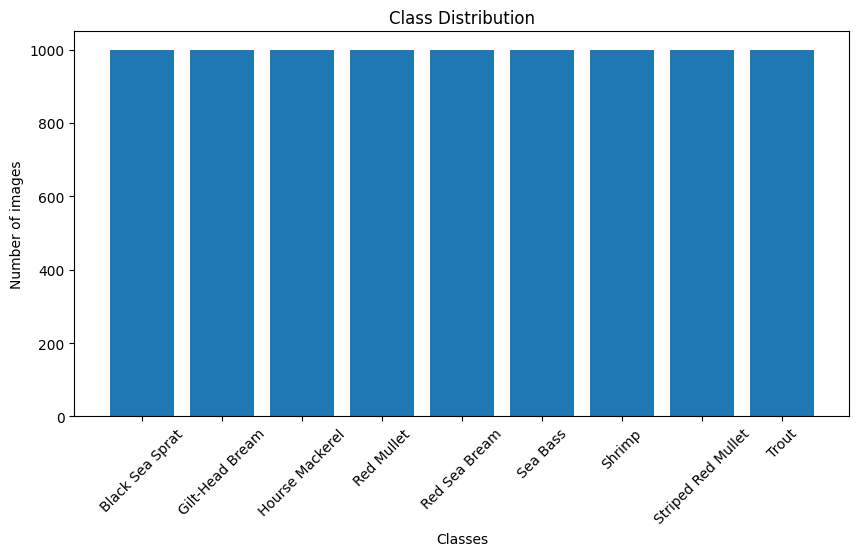

In [3]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Count how many images per class
class_counts = Counter(full_dataset.targets)
print(class_counts)

# Bar plot
plt.figure(figsize=(10,5))
plt.bar(class_names, [class_counts[i] for i in range(num_classes)])
plt.xlabel("Classes")
plt.ylabel("Number of images")
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()

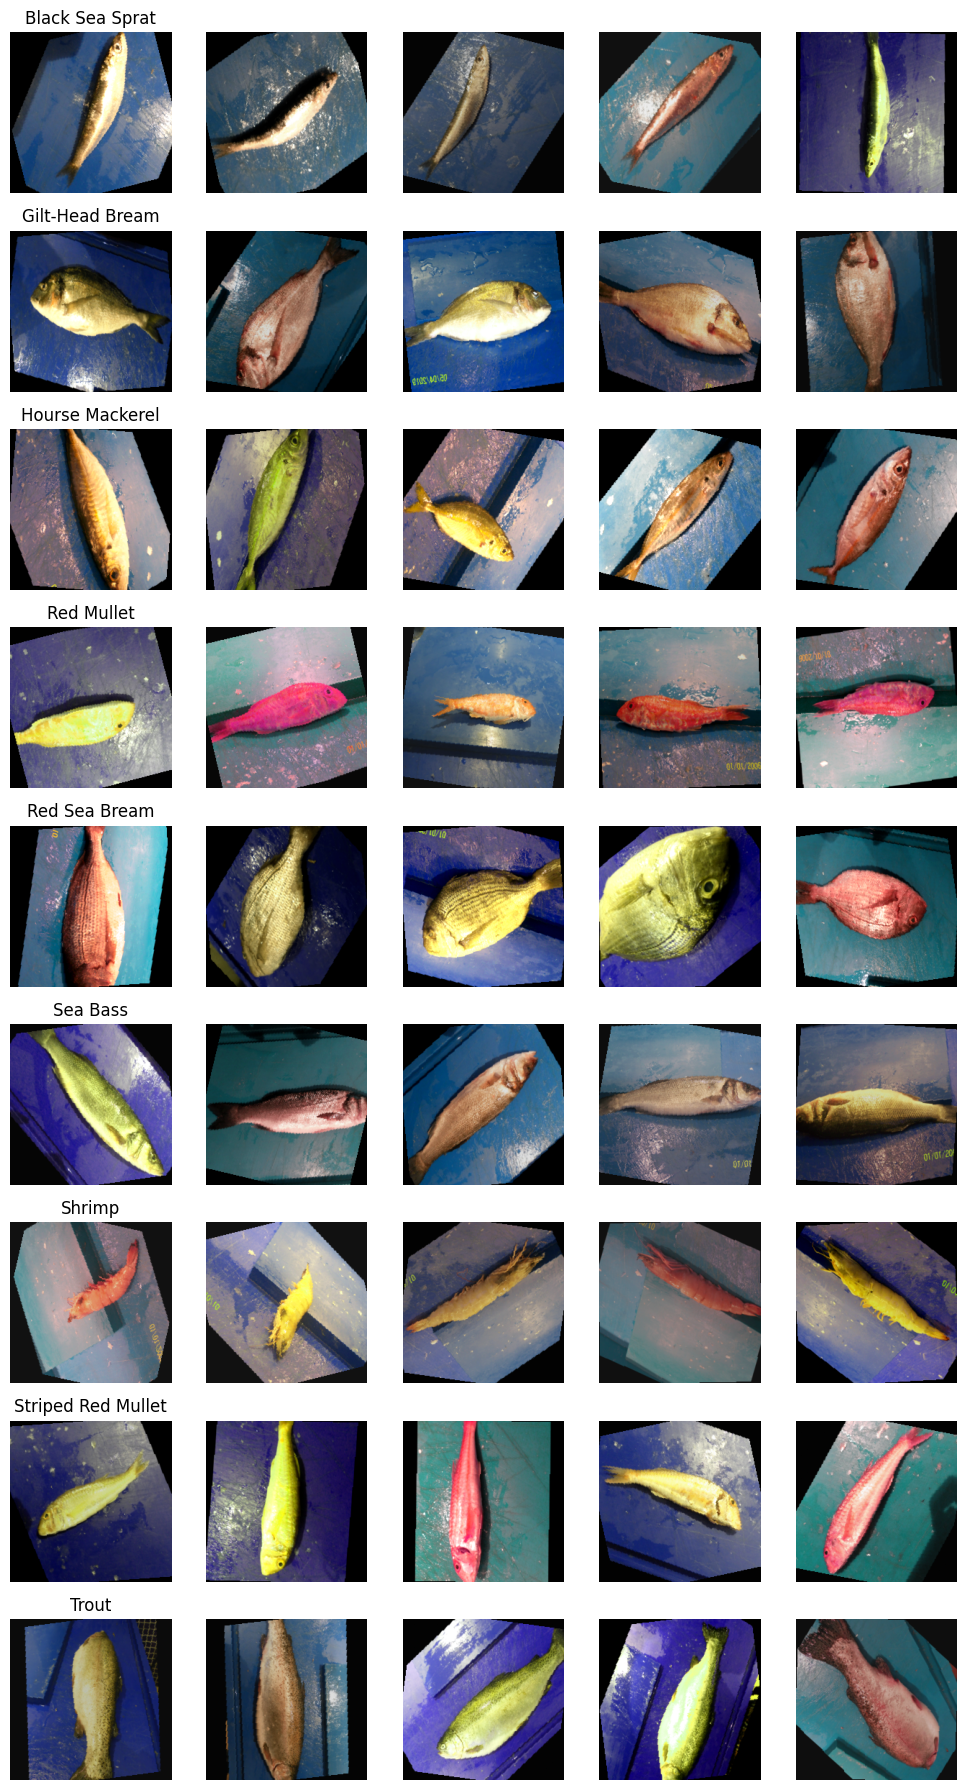

In [4]:
import torchvision.utils as vutils

def show_samples(dataset, classes, n_samples=5):
    fig, axes = plt.subplots(len(classes), n_samples, figsize=(n_samples*2, len(classes)*2))
    for i, cls in enumerate(classes):
        cls_indices = [idx for idx, (_, label) in enumerate(dataset.dataset.samples) if label == i]
        samples_idx = np.random.choice(cls_indices, n_samples, replace=False)
        for j, idx in enumerate(samples_idx):
            img, label = dataset.dataset[idx]
            img = img.permute(1,2,0).numpy()  # Convert from CxHxW to HxWxC
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(cls)
    plt.tight_layout()
    plt.show()

show_samples(train_dataset, class_names, n_samples=5)

## Training the Model

### Helper Functions and Set-Up

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

class FishCNN(nn.Module):
    def __init__(
        self,
        num_classes=10,
        size_inner=128,
        num_inner_layers=1,
        droprate=0.0,
        use_batchnorm=False
    ):
        super().__init__()

        # -------- Convolutional feature extractor --------
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 112x112

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56x56

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28x28

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        feat_dim = 256

        # -------- Dynamic classifier head --------
        layers = []
        in_features = feat_dim

        for _ in range(num_inner_layers):
            layers.append(nn.Linear(in_features, size_inner))

            if use_batchnorm:
                layers.append(nn.BatchNorm1d(size_inner))

            layers.append(nn.ReLU())

            if droprate > 0:
                layers.append(nn.Dropout(droprate))

            in_features = size_inner

        layers.append(nn.Linear(in_features, num_classes))

        self.classifier = nn.Sequential(*layers)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [6]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

criterion = nn.CrossEntropyLoss()

Using device: cuda


In [7]:
import torch.optim as optim

def make_model(
    learning_rate=1e-3,
    num_classes=9,
    size_inner=128,
    num_inner_layers=1,
    droprate=0.0,
    use_batchnorm=False
):
    model = FishCNN(
        num_classes=num_classes,
        size_inner=size_inner,
        num_inner_layers=num_inner_layers,
        droprate=droprate,
        use_batchnorm=use_batchnorm
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    return model, optimizer

In [8]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [9]:
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [10]:
import torch
import os

def train_model(
    model,
    optimizer,
    train_loader,
    criterion,
    device,
    val_loader=None,
    num_epochs=10,
    save_path="model/model.pt"
):
    """
    Train a model. If val_loader is provided, monitor val accuracy and save best model.
    If val_loader is None, train on all data without validation.
    """
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [] if val_loader else None,
        "val_acc": [] if val_loader else None
    }

    best_val_acc = 0.0
    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        # ----------------
        # Validation (if provided)
        # ----------------
        if val_loader:
            val_loss, val_acc = evaluate(model, val_loader, criterion, device)
            history["val_loss"].append(val_loss)
            history["val_acc"].append(val_acc)

            # Save best model based on val accuracy
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save({
                    "model_state": model.state_dict(),
                    "class_names": class_names
                }, save_path)

            print(f"Epoch {epoch+1}/{num_epochs} | "
                  f"Train Acc: {train_acc:.4f} | Train Loss: {train_loss:.4f} | "
                  f"Val Acc: {val_acc:.4f} | Val Loss: {val_loss:.4f}")
        else:
            print(f"Epoch {epoch+1}/{num_epochs} | "
                  f"Train Acc: {train_acc:.4f} | Train Loss: {train_loss:.4f}")

    # Save final model if no validation
    if val_loader is None:
        torch.save({
            "model_state": model.state_dict(),
            "class_names": class_names
        }, save_path)

    return history, model

In [11]:
experiments = [
    # -----------------
    # Baseline: no hidden layer
    # -----------------
    {
        "name": "linear_head",
        "num_inner_layers": 0,
        "size_inner": 128,
        "droprate": 0.0,
        "use_batchnorm": False
    },
    {
        "name": "linear_head_dropout",
        "num_inner_layers": 0,
        "size_inner": 128,
        "droprate": 0.3,
        "use_batchnorm": False
    },

    # -----------------
    # One hidden layer
    # -----------------
    {
        "name": "1_inner",
        "num_inner_layers": 1,
        "size_inner": 128,
        "droprate": 0.0,
        "use_batchnorm": False
    },
    {
        "name": "1_inner_dropout",
        "num_inner_layers": 1,
        "size_inner": 128,
        "droprate": 0.3,
        "use_batchnorm": False
    },
    {
        "name": "1_inner_bn",
        "num_inner_layers": 1,
        "size_inner": 128,
        "droprate": 0.0,
        "use_batchnorm": True
    },
    {
        "name": "1_inner_bn_dropout",
        "num_inner_layers": 1,
        "size_inner": 128,
        "droprate": 0.3,
        "use_batchnorm": True
    },

    # -----------------
    # Two hidden layers
    # -----------------
    {
        "name": "2_inner",
        "num_inner_layers": 2,
        "size_inner": 128,
        "droprate": 0.0,
        "use_batchnorm": False
    },
    {
        "name": "2_inner_dropout",
        "num_inner_layers": 2,
        "size_inner": 128,
        "droprate": 0.3,
        "use_batchnorm": False
    },
    {
        "name": "2_inner_bn",
        "num_inner_layers": 2,
        "size_inner": 128,
        "droprate": 0.0,
        "use_batchnorm": True
    },
    {
        "name": "2_inner_bn_dropout",
        "num_inner_layers": 2,
        "size_inner": 128,
        "droprate": 0.3,
        "use_batchnorm": True
    }
]

In [12]:
all_histories = {}

for exp in experiments:
    print("\n" + "=" * 70)
    print(f"Training: {exp['name']}")
    print("=" * 70)

    model, optimizer = make_model(
        num_classes=num_classes,
        size_inner=exp["size_inner"],
        num_inner_layers=exp["num_inner_layers"],
        droprate=exp["droprate"],
        use_batchnorm=exp["use_batchnorm"]
    )

    history = train_model(
        model=model,
        optimizer=optimizer,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        num_epochs=15,
        device=device
    )

    all_histories[exp["name"]] = history


Training: linear_head
Epoch 1/15 | Train Acc: 0.1872 | Train Loss: 2.0324 | Val Acc: 0.3256 | Val Loss: 1.7581
Epoch 2/15 | Train Acc: 0.3380 | Train Loss: 1.6859 | Val Acc: 0.3700 | Val Loss: 1.5319
Epoch 3/15 | Train Acc: 0.4320 | Train Loss: 1.4400 | Val Acc: 0.4561 | Val Loss: 1.3724
Epoch 4/15 | Train Acc: 0.5154 | Train Loss: 1.2528 | Val Acc: 0.5772 | Val Loss: 1.0841
Epoch 5/15 | Train Acc: 0.5719 | Train Loss: 1.1387 | Val Acc: 0.6600 | Val Loss: 0.9134
Epoch 6/15 | Train Acc: 0.6106 | Train Loss: 1.0521 | Val Acc: 0.7028 | Val Loss: 0.8281
Epoch 7/15 | Train Acc: 0.6517 | Train Loss: 0.9396 | Val Acc: 0.6833 | Val Loss: 0.8225
Epoch 8/15 | Train Acc: 0.6809 | Train Loss: 0.8736 | Val Acc: 0.7411 | Val Loss: 0.7096
Epoch 9/15 | Train Acc: 0.7100 | Train Loss: 0.8095 | Val Acc: 0.6467 | Val Loss: 0.8710
Epoch 10/15 | Train Acc: 0.7350 | Train Loss: 0.7396 | Val Acc: 0.8428 | Val Loss: 0.5213
Epoch 11/15 | Train Acc: 0.7702 | Train Loss: 0.6511 | Val Acc: 0.7789 | Val Loss: 0.6

In [27]:
import matplotlib.pyplot as plt

def plot_histories(histories, metric="val_acc"):
    plt.figure(figsize=(12,6))

    for name, (history, model) in histories.items():
        plt.plot(history[metric], label=name)

    plt.xlabel("Epoch")
    plt.ylabel(metric.replace("_", " ").title())
    plt.title(f"{metric.replace('_', ' ').title()} per experiment")
    plt.legend()
    plt.grid(True)
    plt.show()

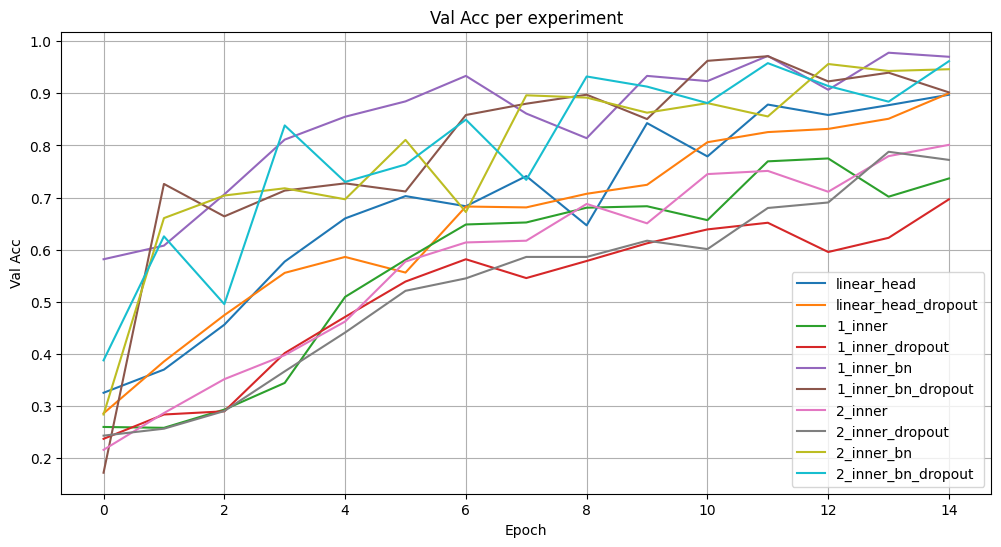

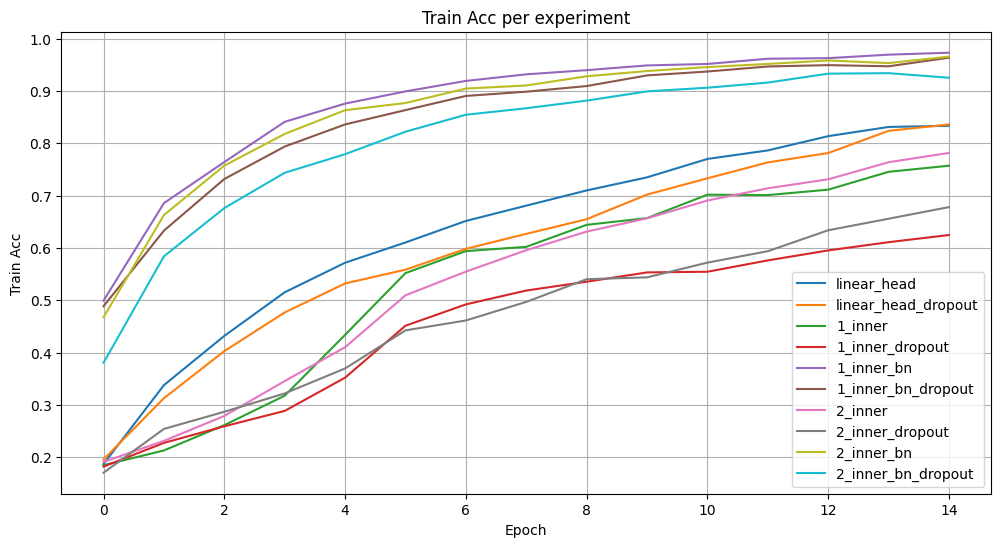

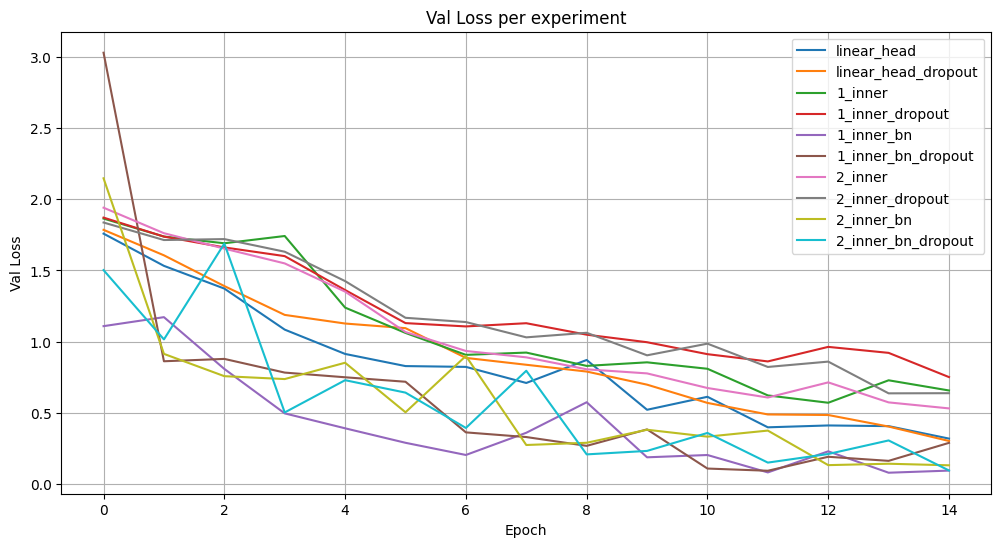

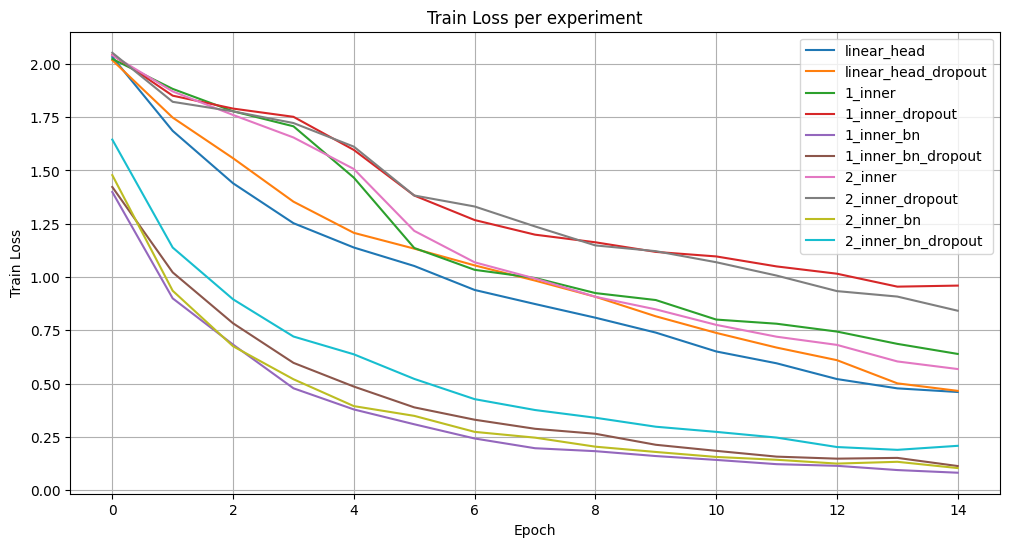

In [31]:
plot_histories(all_histories, metric="val_acc")
plot_histories(all_histories, metric="train_acc")
plot_histories(all_histories, metric="val_loss")
plot_histories(all_histories, metric="train_loss")

In [29]:
import pandas as pd

def build_summary_table(histories):
    rows = []

    for name, (history, model) in histories.items():
        train_acc = history["train_acc"]
        val_acc = history["val_acc"]
        train_loss = history["train_loss"]
        val_loss = history["val_loss"]

        best_epoch = max(range(len(val_acc)), key=lambda i: val_acc[i])

        rows.append({
            "experiment": name,
            "best_val_acc": val_acc[best_epoch],
            "best_epoch": best_epoch + 1,
            "final_train_acc": train_acc[-1],
            "final_val_acc": val_acc[-1],
            "final_train_loss": train_loss[-1],
            "final_val_loss": val_loss[-1],
            "overfit_gap": train_acc[-1] - val_acc[-1]
        })

    return pd.DataFrame(rows).sort_values("best_val_acc", ascending=False)

In [30]:
summary_df = build_summary_table(all_histories)
summary_df

experiment  best_val_acc  best_epoch  final_train_acc  \
4           1_inner_bn      0.977778          14         0.973148   
5   1_inner_bn_dropout      0.971111          12         0.963704   
9   2_inner_bn_dropout      0.961667          15         0.925370   
8           2_inner_bn      0.956111          13         0.965741   
1  linear_head_dropout      0.900000          15         0.836111   
0          linear_head      0.897222          15         0.833519   
6              2_inner      0.801111          15         0.781667   
7      2_inner_dropout      0.787778          14         0.678148   
2              1_inner      0.775000          13         0.757222   
3      1_inner_dropout      0.696667          15         0.624815   

   final_val_acc  final_train_loss  final_val_loss  overfit_gap  
4       0.970000          0.082286        0.094273     0.003148  
5       0.901667          0.113592        0.289125     0.062037  
9       0.961667          0.208508        0.095043    -0.036296  
8       0.946111          0.104082        0.131480     0.019630  
1       0.900000          0.466324        0.302216    -0.063889  
0       0.897222          0.460963        0.318934    -0.063704  
6       0.801111          0.568630        0.530996    -0.019444  
7       0.772222          0.842152        0.637781    -0.094074  
2       0.736667          0.639493        0.656805     0.020556  
3       0.696667          0.960054        0.750819    -0.071852

In [18]:
best_exp = {
        "name": "1_inner_bn",
        "num_inner_layers": 1,
        "size_inner": 128,
        "droprate": 0.0,
        "use_batchnorm": True
    }

model, optimizer = make_model(
    num_classes=num_classes,
    size_inner=best_exp["size_inner"],
    num_inner_layers=best_exp["num_inner_layers"],
    droprate=best_exp["droprate"],
    use_batchnorm=best_exp["use_batchnorm"]
)

model = model.to(device)

In [20]:
num_epochs = 15
history = train_model(
    model=model,
    optimizer=optimizer,
    train_loader=full_train_loader,
    val_loader=None,  # no validation this time
    criterion=criterion,
    num_epochs=num_epochs,
    device=device,
    save_path="model/final_model.pt"
)

Epoch 1/15 | Train Acc: 0.4926 | Train Loss: 1.3834
Epoch 2/15 | Train Acc: 0.6969 | Train Loss: 0.8526
Epoch 3/15 | Train Acc: 0.8149 | Train Loss: 0.5647
Epoch 4/15 | Train Acc: 0.8604 | Train Loss: 0.4073
Epoch 5/15 | Train Acc: 0.8950 | Train Loss: 0.3099
Epoch 6/15 | Train Acc: 0.9190 | Train Loss: 0.2437
Epoch 7/15 | Train Acc: 0.9306 | Train Loss: 0.2006
Epoch 8/15 | Train Acc: 0.9486 | Train Loss: 0.1599
Epoch 9/15 | Train Acc: 0.9537 | Train Loss: 0.1418
Epoch 10/15 | Train Acc: 0.9607 | Train Loss: 0.1172
Epoch 11/15 | Train Acc: 0.9674 | Train Loss: 0.1039
Epoch 12/15 | Train Acc: 0.9718 | Train Loss: 0.0900
Epoch 13/15 | Train Acc: 0.9693 | Train Loss: 0.0901
Epoch 14/15 | Train Acc: 0.9740 | Train Loss: 0.0779
Epoch 15/15 | Train Acc: 0.9797 | Train Loss: 0.0649


In [21]:
# Evaluate on test
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"\nFinal Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")


Final Test Accuracy: 0.9950 | Test Loss: 0.0284


In [42]:
path = '/kaggle/working/model/final_model.pt'
checkpoint = torch.load(path)
model.load_state_dict(checkpoint["model_state"])
model.to(device)
model.eval()

FishCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=9, bias=True)
  )
)

In [36]:
import random
import torch
import matplotlib.pyplot as plt

def test_random_samples(model, dataset, class_names, n=5):
    model.eval()

    indices = random.sample(range(len(dataset)), n)

    for idx in indices:
        image, label = dataset[idx]

        with torch.no_grad():
            image = image.unsqueeze(0).to(device)
            logits = model(image)
            pred = torch.argmax(logits, dim=1).item()

        plt.imshow(image.cpu().squeeze().permute(1, 2, 0))
        plt.title(f"GT: {class_names[label]} | Pred: {class_names[pred]}")
        plt.axis("off")
        plt.show()

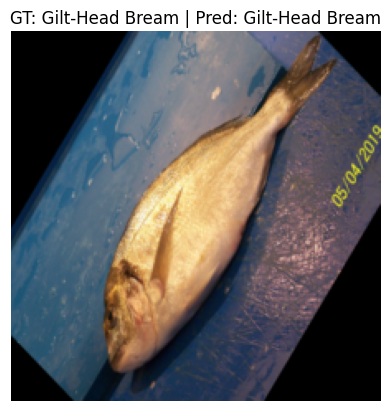

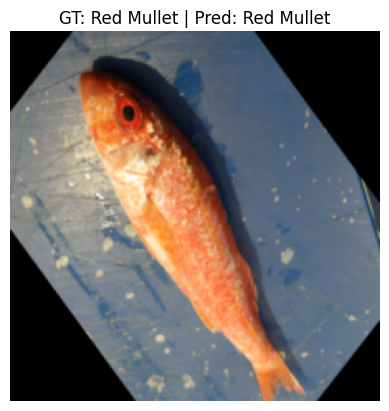

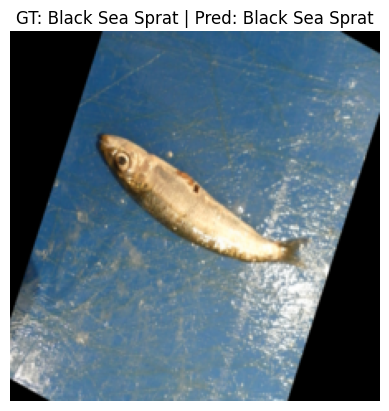

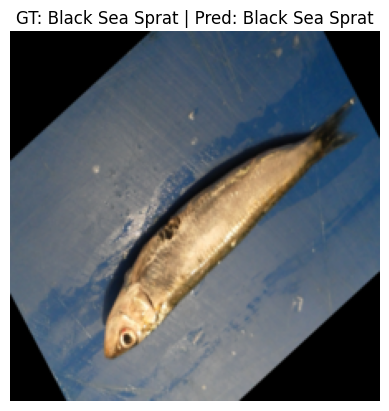

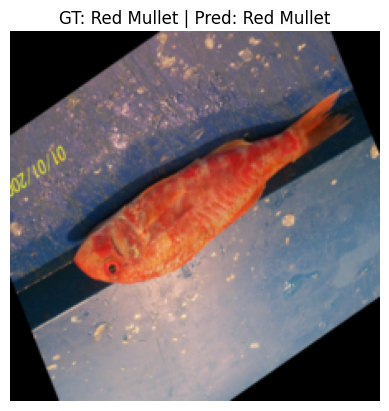

In [47]:
test_random_samples(model, test_dataset, class_names)

In [44]:
image_path = "/kaggle/input/fish-exampletest/fish.jpeg"
img = Image.open(image_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

img_tensor = transform(img).unsqueeze(0)  # add batch dimension
img_tensor = img_tensor.to(device)  # move image to the same device

In [45]:
with torch.no_grad():
    outputs = model(img_tensor)  # shape [1, num_classes]
    _, pred = torch.max(outputs, 1)  # get predicted class index

predicted_class = class_names[pred.item()]
print("Predicted class:", predicted_class)

Predicted class: Trout


In [46]:
probs = torch.nn.functional.softmax(outputs, dim=1)
for cls, p in zip(class_names, probs[0]):
    print(f"{cls}: {p:.4f}")

Black Sea Sprat: 0.0000
Gilt-Head Bream: 0.0000
Hourse Mackerel: 0.0000
Red Mullet: 0.0000
Red Sea Bream: 0.0057
Sea Bass: 0.0000
Shrimp: 0.0000
Striped Red Mullet: 0.0000
Trout: 0.9943
